# Spatial Regression
- In other words, do airBnB hosts care what the prices of nearby listings are?

## First I Run a regular regression, doesn't have to be very good

In [1]:
# there have been changes to the shapely/geopandas combo
# this fixes an error warning
import os
os.environ['USE_PYGEOS'] = '0'

In [2]:
# !pip install spreg
# !pip install libpysal
import shapely
import pandas as pd
from statsmodels.formula.api import ols as sm_ols
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from libpysal.weights import KNN
from libpysal.cg import KDTree
import spreg
import scipy.stats as stats

In [3]:
pd.set_option('display.max_columns', 150)

In [4]:
# Boston airbnb listings data
listings = pd.read_csv('../inputs/listings.csv.gz', compression='gzip')

In [5]:
# getting number of bathrooms as a number for regression (might do as category)
num_pattern = r'(\d+\.*\d*)'
listings['bath_num'] = listings['bathrooms_text'].str.extract(num_pattern).astype(float)

In [6]:
# make the price a float
listings['price'] = listings['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

In [7]:
# list of correlations in listings data
# clearly we need to merge in additional data
# or go straight to avg for neighborhood/tract for prediction
#     - see if there are census-zone-level stats that correlate better
listings.corr(numeric_only=True).iloc[12]

id                                              0.014822
scrape_id                                            NaN
host_id                                         0.027121
host_listings_count                             0.011211
host_total_listings_count                      -0.011811
neighbourhood_group_cleansed                         NaN
latitude                                        0.081329
longitude                                       0.090658
accommodates                                    0.382871
bathrooms                                            NaN
bedrooms                                        0.213189
beds                                            0.355472
price                                           1.000000
minimum_nights                                 -0.135298
maximum_nights                                  0.018940
minimum_minimum_nights                         -0.083016
maximum_minimum_nights                         -0.028242
minimum_maximum_nights         

In [8]:
# get some variables that I think could predict price + geography
listings_4reg = listings[['bath_num','minimum_nights','bathrooms_text','beds', 'bedrooms','accommodates','price','latitude', 'longitude']].dropna().reset_index(drop=True)

In [9]:
# create log(price) for regression
listings_4reg = (listings_4reg.assign(l_price = np.log(listings_4reg['price'])))

In [10]:
# create regression a la assignment 6
#     - terrible r2 doesn't bode well for predictions
#     - But it doesn't matter for this part, cus we just wanna see if there is spatial correlation
reg = sm_ols('l_price ~ accommodates + bathrooms_text + bedrooms', data=listings_4reg).fit()

In [11]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     193.7
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        04:28:49   Log-Likelihood:                -2424.6
No. Observations:                3343   AIC:                             4893.
Df Residuals:                    3321   BIC:                             5028.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              4.4240      0.502      8.816      0.000       3.440       5.408
bathrooms_text[T.0 shared baths]      -0.3100      0.506     -0.612      0.541      -1.303       0.683
bathrooms_text[T.1 bath]               0.3601      0.502      0.718      0.473      -0.623       1.344
bathrooms_text[T.1 private bath]       0.2626      0.503      0.522      0.602      -0.724       1.249
bathrooms_text[T.1 shared bath]       -0.3564      0.502     -0.710      0.478      -1.341       0.628
bathrooms_text[T.1.5 baths]            0.3094      0.504      0.614      0.539      -0.678       1.297
bathrooms_text[T.1.5 shared baths]    -0.3364      0.505     -0.666      0.506      -1.327       0.654
bathrooms_text[T.2 baths]              0.7077      0.502      1.409      0.159      -0.277       1.692
bathrooms_text[T.2 shared baths]      -0.3286      0.503     -0.653      0.514      -1.315       0.658
bathrooms_text[T.2.5 baths]            0.9035      0.506      1.787      0.074      -0.088       1.895
bathrooms_text[T.2.5 shared baths]    -0.1551      0.524     -0.296      0.767      -1.182       0.872
bathrooms_text[T.3 baths]              0.7063      0.509      1.388      0.165      -0.291       1.704
bathrooms_text[T.3 shared baths]      -0.3808      0.529     -0.720      0.472      -1.418       0.657
bathrooms_text[T.3.5 baths]            1.0864      0.520      2.088      0.037       0.066       2.107
bathrooms_text[T.3.5 shared baths]    -0.3354      0.709     -0.473      0.636      -1.726       1.055
bathrooms_text[T.4 baths]              1.1874      0.553      2.149      0.032       0.104       2.271
bathrooms_text[T.4 shared baths]      -0.5045      0.709     -0.711      0.477      -1.895       0.886
bathrooms_text[T.4.5 baths]            0.9071      0.581      1.561      0.119      -0.232       2.047
bathrooms_text[T.5 baths]              1.3223      0.563      2.347      0.019       0.218       2.427
bathrooms_text[T.6 baths]              1.1510      0.584      1.970      0.049       0.005       2.297
accommodates                           0.1028      0.007     15.527      0.000       0.090       0.116
bedrooms                              -0.0150      0.015     -1.010      0.313      -0.044       0.014
==============================================================================
Omnibus:                      642.616   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5086.835
Skew:                           0.691   Prob(JB):                         0.00
Kurtosis:                       8.883   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors assume

## This [link](https://stats.stackexchange.com/questions/26176/removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo) helps with the difference between intercept and no-intercept regressions


In [12]:
# doing an OLS a slightly different way
# no intercept... but much higher r-squared (when using l_price... weird)
# better for this report, but not sure I can use it in predicitons

explanatory_variables = ['accommodates', 'bath_num', 'bedrooms']

reg = sm.OLS(listings_4reg['l_price'], listings_4reg[explanatory_variables])
basic_ols_res = reg.fit()
basic_ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                l_price   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              7763.
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                        0.00
Time:                        04:28:49   Log-Likelihood:                         -6668.8
No. Observations:                3343   AIC:                                  1.334e+04
Df Residuals:                    3340   BIC:                                  1.336e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
accommodates     0.1412      0.018      7.703      0.000       0.105       0.177
bath_num         2.1012      0.043     48.504      0.000       2.016       2.186
bedrooms         0.6918      0.027     25.317      0.000       0.638       0.745
==============================================================================
Omnibus:                     1625.765   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14606.628
Skew:                          -2.115   Prob(JB):                         0.00
Kurtosis:                      12.326   Cond. No.                         6.75
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Skewness: 0.322002
Kurtosis: 0.365186


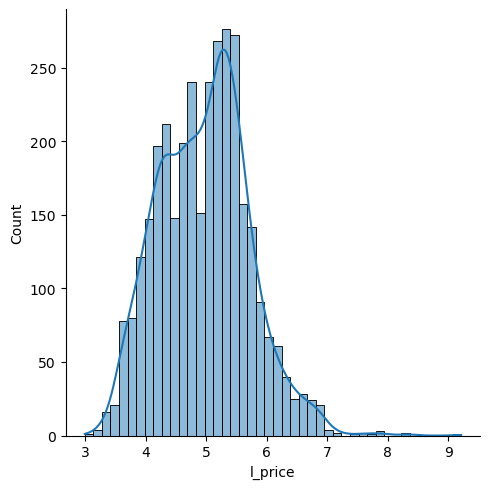

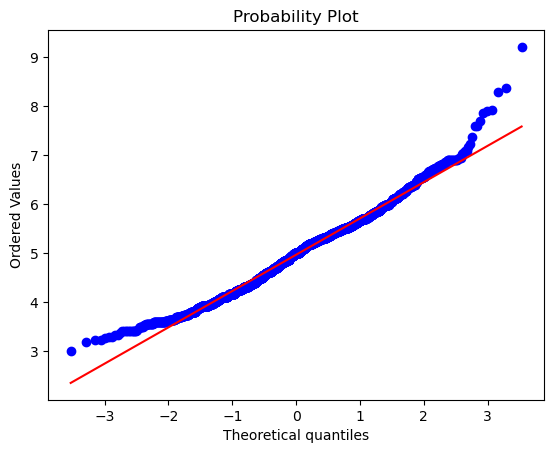

In [13]:
# examining price problems... grrr
sns.displot(listings_4reg['l_price'], kde=True,);
fig = plt.figure()
res = stats.probplot(listings_4reg['l_price'], plot=plt)
print("Skewness: %f" % listings_4reg['l_price'].skew())
print("Kurtosis: %f" % listings_4reg['l_price'].kurt())

## Now I add in spatial weights and compare

In [14]:
# create spatial weights based on the 4 nearest neighbors
# idk what that error is about
#      - wouldn't there always be a nearest neighbor?
coordinates = np.column_stack((listings_4reg['longitude'], listings_4reg['latitude']))
kd = KDTree(np.array(coordinates))
w = KNN.from_array(kd, k=4)
w

C:\Users\dbawa\anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 33 disconnected components.
  warnings.warn(message)


#### Spatial two stage least squares (S2SLS) with results and diagnostics
[link](https://spreg.readthedocs.io/en/latest/generated/spreg.GM_Lag.html) to docs
- This part, without the part above, could suffice potentially
    - The picture is fairly clear when I use "price" instead of "l_price"
        - But I should figure out why

In [15]:
reg_wGEO = spreg.GM_Lag(listings_4reg['l_price'].values[:, None],
                        listings_4reg[explanatory_variables].values,
                        w=w,
                        name_x=explanatory_variables,
                        name_y='l_price')

In [16]:
print(reg_wGEO.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     l_price                Number of Observations:        3343
Mean dependent var  :      4.9669                Number of Variables   :           5
S.D. dependent var  :      0.7455                Degrees of Freedom    :        3338
Pseudo R-squared    :      0.5123
Spatial Pseudo R-squared:  0.3986

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       3.1591105       0.1473044      21.4461402       0.0000000
        accommodates       0.1819085       0.0058870      30.9001830       0.0000000
            bath_num       0.1154886       0.0166131       

In [17]:
# copied from someone else's repo
# I think this finds MSE manually using .predy, and also using .mse_total
geospatial_ols_mse = ((listings_4reg['l_price'] - reg_wGEO.predy.flatten()) ** 2).mean()
print("OLS".ljust(5), ":", basic_ols_res.mse_total)
print("OLS+W".ljust(5), ":", geospatial_ols_mse)

OLS   : 25.225415020191463
OLS+W : 0.27346863539406036


### That was fun, IDT everything is correct yet

## The Takeaways below were before I switched to using "price" instead of "l_price"
- The difference between the two is weirdly large and needs investigation
    - Cleaning fees are a place to start, but not likely the only culprit

### Main Takeaways from this section
- I'm still iffy on the part with KNN, cus idrk what the "k=" parameter is doing
- W_actual price is the coefficient that corresponds to the spatial weight of listing prices
    - It is relatively low, but not 0
    - Is it high enough to interpret that there is neighbor-based price setting?
        - If it is, then it only has a small effect
    - Is it low enough to interpret that there is no neighbor-based price setting?
        - If it is, then "bedrooms" is also statistical noise
        - "bedrooms" is only statistical noise when spatial weight is included
    - The problem is that my other coefficients are also low, so interpreting W_actual_price is tough.
- The MSE gives a clearer picture, I just have to ensure those numbers are correct
    - Currently the interpretation is that adding spatial weight decreases the mean squ. error (increases accuracy)
    - This implies that hosts **DO** in fact take neighbor's lists prices into consideration
        - But there are lots of other factors I can think of that affect this correlation
- I think I need professor help to make sure I am doing/interpreting this right